# Make anaphase time predictions based on the first 3 observations of the relative cumulative surface


In [1]:
%matplotlib inline
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from skimage import measure # to get contours from masks
import sklearn

import napari

sns.set_theme()

C:\ProgramData\Anaconda3\lib\site-packages\napari\_qt\__init__.py:37: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.7. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


## Loading data

In [27]:
os.chdir("D:/Hugo/Anaphase/Analyse_Descriptive")
data = pd.read_csv("Analysis_BF_f0001-1-100.1.csv", sep=";", comment="#", index_col="idx")
data = data[data["time_to_anaphase"] >= 0]

print(data.shape)
data.head()

from sklearn.model_selection import train_test_split

# train test split
indices = np.random.permutation(data.index.unique())

# get the first three observations of each time series
train_size = 50
time_series_length = 3
X_train, X_test, y_train, y_test = [], [], [], []
for i in indices[:train_size]:
    X_train.append(data.loc[i]["cum_relat_surf"][:time_series_length])
    y_train.append(data[data["anaphase"]].loc[i]["time"])

for i in indices[train_size:]:
    X_test.append(data.loc[i]["cum_relat_surf"][:time_series_length])
    y_test.append(data[data["anaphase"]].loc[i]["time"])
    
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(495, 13)
(50, 3) (16, 3) (50,) (16,)


## Random Forest Regressor

R^2 coefficient : 0.87
(50,)


Text(0.5, 1.0, 'Random Forest regression predictions on the training set')

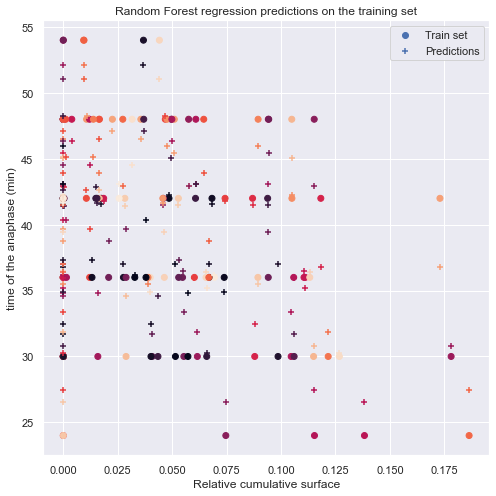

In [43]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor().fit(X_train, y_train)

print(f"R^2 coefficient : {round(model.score(X_train, y_train), 2)}")

predictions_on_train_set = model.predict(X_train)
print(predictions_on_train_set.shape)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_train, np.concatenate((np.expand_dims(y_train, axis=-1), np.expand_dims(y_train, axis=-1), np.expand_dims(y_train, axis=-1)), axis=-1), 
           c=np.concatenate((np.expand_dims(indices[:50], axis=-1), np.expand_dims(indices[:50], axis=-1), np.expand_dims(indices[:50], axis=-1))), label="Train set")
ax.scatter(X_train, np.concatenate((np.expand_dims(predictions_on_train_set, axis=-1), np.expand_dims(predictions_on_train_set, axis=-1), np.expand_dims(predictions_on_train_set, axis=-1)), axis=-1),
           marker="+", c=np.concatenate((np.expand_dims(indices[:50], axis=-1), np.expand_dims(indices[:50], axis=-1), np.expand_dims(indices[:50], axis=-1))), label="Predictions")
ax.legend()
ax.set_xlabel("Relative cumulative surface")
ax.set_ylabel("time of the anaphase (min)")
ax.set_title("Random Forest regression predictions on the training set")

Mean squared error : 5.501250000000001


Text(0.5, 1.0, 'Observations given the sign of (y_true - y_pred)')

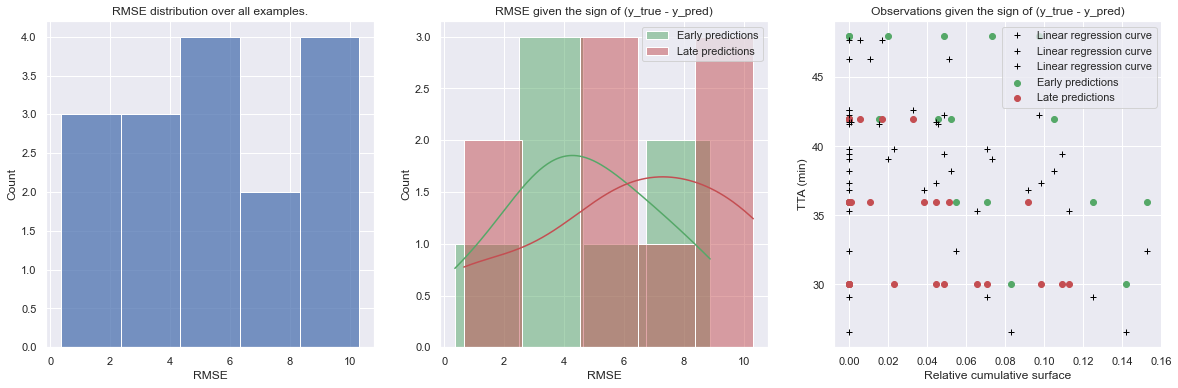

In [47]:
predictions_on_test_set = model.predict(X_test)

# evaluation with the clasical RMSE
losses, signed_losses = [], []
for obs, pred, gt in zip(X_test, predictions_on_test_set, y_test):
    loss = np.sqrt((pred - gt) ** 2)
    signed_losses.append(gt - pred)
    losses.append(loss)
losses = np.array(losses) 
signed_losses = np.array(signed_losses)

print(f"Mean squared error : {losses.mean()}")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# RMSE distribution
sns.histplot(losses, ax=axes[0])
axes[0].set_title("RMSE distribution over all examples.")
axes[0].set_xlabel("RMSE")

# Conditional distributions given the sign of the error
sns.histplot(losses[signed_losses >= 0], color="g", kde=True, label="Early predictions", ax=axes[1])
sns.histplot(losses[signed_losses < 0], color="r", kde=True, label="Late predictions", ax=axes[1])
axes[1].legend()
axes[1].set_xlabel("RMSE")
axes[1].set_title("RMSE given the sign of (y_true - y_pred)")

# conditional distributions of the points
axes[2].scatter(X_test[signed_losses >= 0], np.concatenate((np.expand_dims(y_test[signed_losses >= 0], axis=-1), np.expand_dims(y_test[signed_losses >= 0], axis=-1), np.expand_dims(y_test[signed_losses >= 0], axis=-1)), axis=-1),
                c="g", label="Early predictions")
axes[2].scatter(X_test[signed_losses < 0], np.concatenate((np.expand_dims(y_test[signed_losses < 0], axis=-1), np.expand_dims(y_test[signed_losses < 0], axis=-1), np.expand_dims(y_test[signed_losses < 0], axis=-1)), axis=-1),
                c="r", label="Late predictions")
axes[2].plot(X_test, predictions_on_test_set, "+", c="black", label="Linear regression curve")
axes[2].legend()
axes[2].set_xlabel("Relative cumulative surface")
axes[2].set_ylabel("TTA (min)")
axes[2].set_title("Observations given the sign of (y_true - y_pred)")